#Тестовое задание МТС

*  выполнила Озерова Дарья

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import optuna
from collections import defaultdict
from collections import Counter

from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder

import sklearn.metrics as metrics
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from functools import partial
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.colors as mc
import colorsys

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Вспомогательные функции для визуализации распределения данных для бинарных признаков

def pie_plot(column, data=None, title=None, ax=None, fontsize=15, explode=0,
             autopct='%1.1f%%', shadow=None, figsize=(10, 6), colors=None, color_with_label=None):
    if type(column) == str:
        target = data[column].value_counts()
    else:
        target = column.value_counts()

    explode = [explode for _ in range(len(target))]

    if color_with_label is not None:
        colors = [color_with_label[key] for key in target.index]

    if ax is not None:
        if title is not None:
            ax.set_title(title, fontsize=fontsize)

        ax.pie(target, labels=target.index, autopct=autopct, shadow=shadow, explode=explode, colors=colors)
    else:
        fig = plt.figure(figsize=figsize)

        if title is not None:
            plt.title(title, fontsize=fontsize)

        plt.pie(target, labels=target.index, autopct=autopct, shadow=shadow, explode=explode, colors=colors)


def compare_plots(shape, columns, titles=None, data=None, kind='pie', explode=0, color=None,
                  fontsize=10, autopct='%1.1f%%', figsize=(20, 10), shadow=None, color_with_label=None):

    fig, axes = plt.subplots(*shape, figsize=figsize)

    for i, ax in enumerate(axes.ravel()):
        title = titles[i] if titles is not None else None

        if kind == 'pie':
            pie_plot(columns[i], data=data, title=title, ax=ax, fontsize=fontsize, colors=color,
                     autopct=autopct, figsize=figsize, explode=explode, shadow=shadow,
                     color_with_label=color_with_label)
        else:
            raise TypeError

In [95]:
# Вспомогательные функции для отрисовки ROC кривой

def lighten_color(color, amount=0.5):
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def roc_curve(model, x_text_data, y_text_data):
  preds = model.predict_proba(x_text_data)[:,1]
  fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
  roc_auc = metrics.auc(fpr, tpr)

  print(f'ROC AUC score - {roc_auc_score(y_test, model.predict(X_test))}')

  plt.figure(figsize=(6,4.7))
  plt.title('Receiver Operating Characteristic (ROC)', fontsize=10)
  plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc, color = "#FF5733")
  plt.fill_between(fpr, tpr, np.zeros_like(tpr), color=lighten_color("#FF5733", 0.3))
  plt.plot([0, 1], [0, 1], label = 'Baseline', dashes=[4, 4], color="#2471A3")
  plt.legend(loc = 'lower right', fontsize=8.5)
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate', fontsize=8.5)
  plt.xlabel('False Positive Rate', fontsize=8.5)
  plt.show()

In [ ]:
# Вспомогательные функции для отрисовки Confusion Matrix

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def confusion_matr(model, x_data_test, y_data_test):
  y_pred = model.predict_proba(x_data_test)[:, 1]
  y_pred_c = model.predict(x_data_test)
  y_test = y_data_test

  print(f'F1 on test - {f1_score(y_test, y_pred_c)}')
  print(f'precision on test - {precision_score(y_test, y_pred_c)}')
  print(f'recall on test - {recall_score(y_test, y_pred_c)}')

  cm = confusion_matrix(y_test, y_pred_c, labels=[0,1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=[0,1])
  disp.plot(cmap='Blues_r') #'Blues_r' 'OrRd_r'
  plt.show()

### Препроцессинг данных

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/telco-customer-churn.csv')
data.describe()

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,penaltytoswitch,totalminsusedinlastmonth,unpaidbalance,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
count,20468.000000,20468.000000,20468.000000,20468.000000,2.046800e+04,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.0,20468.000000
mean,45.334327,124446.818253,0.035021,0.015239,4.220203e+09,4757.953342,59.630252,1.499169,3.489252,49.366816,248.792603,249.740522,126.656879,0.496528,3521.696306,721.521057,0.091020,2015.0,1.611687
std,19.624577,72129.392001,0.022996,0.011213,3.365196e+08,2751.070062,34.652681,1.119153,2.289740,28.874138,144.247247,144.198066,70.367800,0.288220,1959.642260,225.677596,0.287645,0.0,0.621895
min,12.000000,4.000000,0.000000,0.000000,1.022955e+08,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.0,1.000000
25%,28.000000,61898.000000,0.010000,0.010000,4.251031e+09,2372.750000,29.000000,0.000000,1.000000,24.000000,124.000000,126.000000,66.000000,0.250000,2047.750000,582.000000,0.000000,2015.0,1.000000
50%,45.000000,123689.500000,0.040000,0.020000,4.251054e+09,4754.000000,60.000000,2.000000,3.000000,49.000000,249.000000,249.000000,122.000000,0.500000,3365.000000,721.000000,0.000000,2015.0,2.000000
75%,62.000000,187065.250000,0.060000,0.030000,4.251077e+09,7141.250000,90.000000,3.000000,5.000000,74.000000,373.000000,374.000000,191.000000,0.750000,4786.250000,862.000000,0.000000,2015.0,2.000000
max,79.000000,249987.000000,0.070000,0.030000,4.251100e+09,9525.000000,119.000000,3.000000,7.000000,99.000000,499.000000,499.000000,249.000000,0.990000,16662.000000,1439.000000,1.000000,2015.0,3.000000


In [ ]:
data.dropna()
data.drop_duplicates()
data.shape, data[data.churn == 0].shape, data[data.churn == 1].shape

((20468, 29), (18605, 29), (1863, 29))

#### В выборке присутствует проблема дисбаланса классов. Посмотрим на распределение отдельных фичей для каждого из классов.

In [ ]:
state_counts_0 = defaultdict(int)
state_counts_1 = defaultdict(int)

for idx, row in data.iterrows():
    states = row['state'].split()
    for state in states:
        if row['churn'] == 0:
            state_counts_0[state] += 1
        else:
            state_counts_1[state] += 1

state_counts_df_0 = pd.DataFrame(list(state_counts_0.items()),
                                 columns=['State', 'Count']).sort_values('State', ascending = False)
state_counts_df_1 = pd.DataFrame(list(state_counts_1.items()),
                                 columns=['State', 'Count']).sort_values('State', ascending = False)

In [ ]:
fig_0 = px.bar(state_counts_df_0[:30], x='State', y='Count',
             labels={'State': 'State', 'Count': 'Count'}, title="Distribution of state attribute values ​​for the class 0", width=1000, height=600)

fig_0.show()

In [ ]:
fig_1 = px.bar(state_counts_df_1[:30], x='State', y='Count',
             labels={'State': 'State', 'Count': 'Count'}, title="Distribution of state attribute values ​​for the class 1", width=1000, height=600)
fig_1.show()

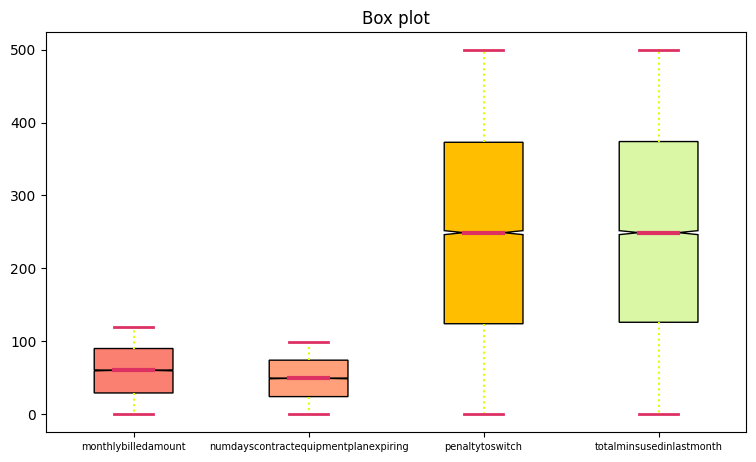

In [ ]:
data_boxplots = [data['monthlybilledamount'], data['numdayscontractequipmentplanexpiring'], data['penaltytoswitch'], data['totalminsusedinlastmonth']]

fig = plt.figure(figsize =(7, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data_boxplots, patch_artist = True,
                notch ='True', vert = 1)

colors = ['#FA8072', '#FFA07A',
          '#FFBF00', '#DAF7A6']

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

for whisker in bp['whiskers']:
    whisker.set(color ='#DFFF00',
                linewidth = 1.5,
                linestyle =":")

for cap in bp['caps']:
    cap.set(color ='#DE3163',
            linewidth = 2)

for median in bp['medians']:
    median.set(color ='#DE3163',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#DE3163',
              alpha = 0.5)

ax.set_xticklabels(['monthlybilledamount', 'numdayscontractequipmentplanexpiring',
                    'penaltytoswitch', 'totalminsusedinlastmonth'], fontsize=7)

plt.title("Box plot")
plt.show()

In [ ]:
data['callingnum'] = np.log1p(data['callingnum'])

### Преобразование категориальных призаков

In [ ]:
data.nunique()

age                                       68
annualincome                            9508
calldroprate                               8
callfailurerate                            4
callingnum                              9525
customerid                              9525
customersuspended                          2
education                                  4
gender                                     2
homeowner                                  2
maritalstatus                              2
monthlybilledamount                      120
noadditionallines                          1
numberofcomplaints                         4
numberofmonthunpaid                        8
numdayscontractequipmentplanexpiring     100
occupation                                 3
penaltytoswitch                          500
state                                     50
totalminsusedinlastmonth                 500
unpaidbalance                            250
usesinternetservice                        2
usesvoices

In [ ]:
binary_data= ['customersuspended', 'gender', 'homeowner', 'maritalstatus', 'usesinternetservice', 'usesvoiceservice']

for bin_col in binary_data:
  data[bin_col] = data[bin_col].replace(to_replace=data[bin_col].unique(), value=['0', '1']).astype(int)

binary_categorical_data = data.loc[:, binary_data]

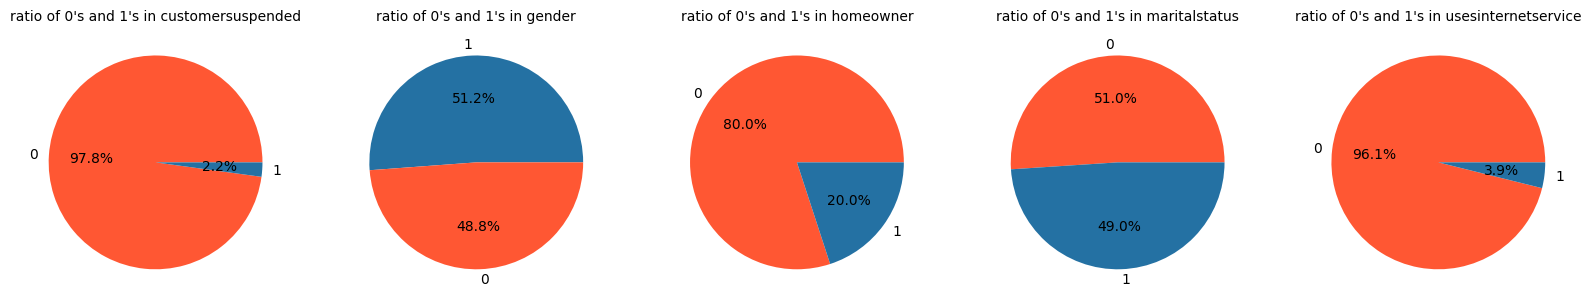

In [ ]:
titles = [f"ratio of 0's and 1's in {b}" for b in binary_categorical_data]
colors = {
    0: "#FF5733",
    1: "#2471A3",
}

compare_plots((1,5), binary_data, titles=titles, data=binary_categorical_data, color_with_label=colors)

Поскольку в датасете есть константные призанки, исключим их

In [ ]:
data = data.drop(columns = ['noadditionallines', 'year'])

In [ ]:
categorical_data = ["education", "occupation" ,"penaltytoswitch", "state"]
enc = OrdinalEncoder()
data[categorical_data] = enc.fit_transform(data[categorical_data])

### Подготовка обучающей выборки

In [ ]:
X = data.drop(columns='churn')
y = data.churn.astype(int)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.40, random_state=42, stratify= y)

print('Original dataset shape %s' % Counter(y_train))
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))

X_test, X_val, y_test, y_val = train_test_split( X_test, y_test, test_size=0.30, random_state=42, stratify= y_test)
X_val, y_val = ros.fit_resample(X_val, y_val)

Original dataset shape Counter({0: 11162, 1: 1118})
Resampled dataset shape Counter({0: 11162, 1: 11162})


### Подбор модели: Random Forest

In [125]:
def optimize_rf(trial):
    params = {
        "n_estimators": trial.suggest_int(name="n_estimators", low=100, high=500, step=100),
        "max_features": trial.suggest_categorical(name="max_features", choices=['auto', 'sqrt']),
        "max_depth": trial.suggest_int(name="max_depth", low=10, high=110, step=20),
        "min_samples_split": trial.suggest_int(name="min_samples_split", low=2, high=10, step=2),
        "min_samples_leaf": trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)
    }
    model = RandomForestClassifier(random_state=42, **params)

    cv_score = cross_val_score(model, X_train, y_train, n_jobs=4, scoring = "f1", cv=10)
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy

study = optuna.create_study()
study.optimize(optimize_rf, n_trials=10)

[I 2024-01-25 23:11:29,821] A new study created in memory with name: no-name-c573f77b-ba08-4bd8-b7cf-444711e26589
[I 2024-01-25 23:12:05,162] Trial 0 finished with value: 0.9000661466797011 and parameters: {'n_estimators': 100, 'max_features': 'auto', 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9000661466797011.
[I 2024-01-25 23:14:40,624] Trial 1 finished with value: 0.9999103541012999 and parameters: {'n_estimators': 400, 'max_features': 'sqrt', 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9000661466797011.
[I 2024-01-25 23:16:42,507] Trial 2 finished with value: 0.9999103541012999 and parameters: {'n_estimators': 300, 'max_features': 'auto', 'max_depth': 90, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9000661466797011.
[I 2024-01-25 23:17:20,722] Trial 3 finished with value: 0.9999103541012999 and parameters: {'n_estimators': 100, 'max_features': 's

In [126]:
best_rf = RandomForestClassifier(random_state=42, **study.best_params)
best_rf.fit(np.vstack([X_train, X_val]), y_train.append(y_val))

<ipython-input-126-b1dfb343d62b>:2: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



RandomForestClassifier(max_depth=10, max_features='auto', n_estimators=400,
                       random_state=42)

### Метрики качества: Random forest

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



F1 on test - 0.429042904290429
precision on test - 0.284375
recall on test - 0.8733205374280231


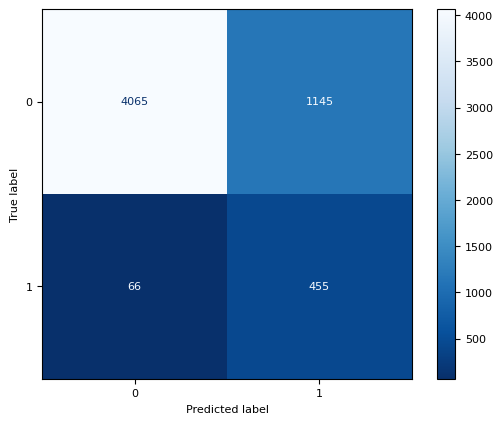

In [127]:
confusion_matr(best_rf, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



ROC AUC score - 0.8267754318618042


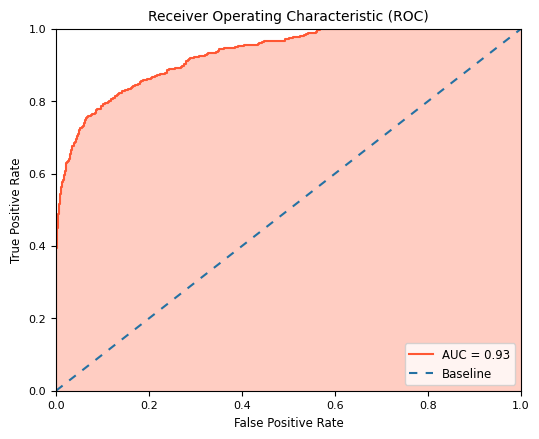

In [128]:
roc_curve(best_rf, X_test, y_test)

In [129]:
print("\033[1m{}\033[0m".format("Classification Report:"))
print(classification_report(y_test, best_rf.predict(X_test)))

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



              precision    recall  f1-score   support

           0       0.98      0.78      0.87      5210
           1       0.28      0.87      0.43       521

    accuracy                           0.79      5731
   macro avg       0.63      0.83      0.65      5731
weighted avg       0.92      0.79      0.83      5731



### Подбор модели: Градиентный бустинг: LGBM

In [107]:
def optimize_lgbm(trial, X_train, y_train, X_val, y_val):
    params = {
        "objective": "binary",
        "metric": "f1_score",
        "class_weight": "balanced",
        "n_estimators": 1000,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-1, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 150, 2**13),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = lgb.LGBMClassifier(random_state = 42, **params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    val_met = f1_score(y_val, preds)
    return val_met

In [116]:
optimization_function = partial(optimize_lgbm, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
study = optuna.create_study(direction="maximize")
study.optimize(optimization_function, n_trials=10)

[I 2024-01-25 22:46:44,607] A new study created in memory with name: no-name-ebd95386-d01a-4475-8a73-4358f8143013
[I 2024-01-25 22:46:58,725] Trial 0 finished with value: 0.8172669491525424 and parameters: {'learning_rate': 0.1592059099398755, 'num_leaves': 4930, 'subsample': 0.7650700988066388, 'colsample_bytree': 0.8855942952542709, 'min_data_in_leaf': 7}. Best is trial 0 with value: 0.8172669491525424.
[I 2024-01-25 22:47:14,565] Trial 1 finished with value: 0.8120180802977931 and parameters: {'learning_rate': 0.12258392356591649, 'num_leaves': 6927, 'subsample': 0.955314111322803, 'colsample_bytree': 0.9998775929728763, 'min_data_in_leaf': 17}. Best is trial 0 with value: 0.8172669491525424.
[I 2024-01-25 22:47:21,530] Trial 2 finished with value: 0.7938478143550999 and parameters: {'learning_rate': 0.19035077705164477, 'num_leaves': 1263, 'subsample': 0.20394222081857644, 'colsample_bytree': 0.4488858572001121, 'min_data_in_leaf': 24}. Best is trial 0 with value: 0.817266949152542

In [117]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  10
Best trial:
  Value: 0.8185899128597834
  Params: 
    learning_rate: 0.16330837163624567
    num_leaves: 8148
    subsample: 0.35414629935990427
    colsample_bytree: 0.11949341271937002
    min_data_in_leaf: 28


In [118]:
best_mdl = lgb.LGBMClassifier(**trial.params, verbosity=-1)
best_mdl.fit(np.vstack([X_train, X_val]), y_train.append(y_val))

<ipython-input-118-6fa64d547767>:2: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



LGBMClassifier(colsample_bytree=0.11949341271937002,
               learning_rate=0.16330837163624567, min_data_in_leaf=28,
               num_leaves=8148, subsample=0.35414629935990427, verbosity=-1)

### Метрики качества: LGBM

F1 on test - 0.875
precision on test - 0.9975429975429976
recall on test - 0.7792706333973128


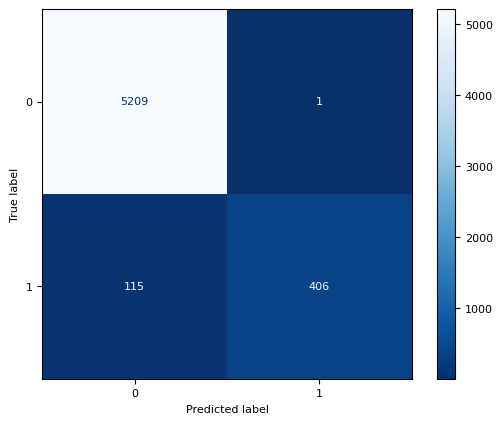

In [119]:
confusion_matr(best_mdl, X_test, y_test)

ROC AUC score - 0.8895393474088291


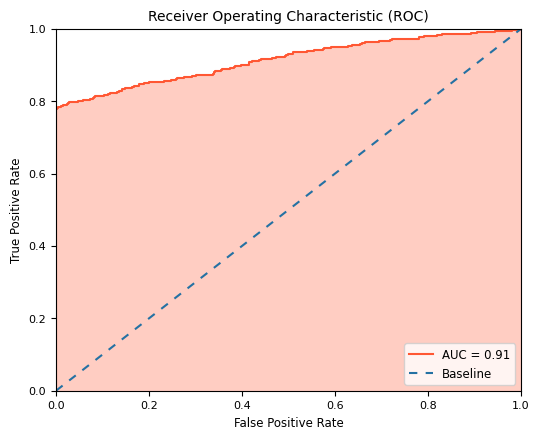

In [120]:
roc_curve(best_mdl, X_test, y_test)

In [121]:
print("\033[1m{}\033[0m".format("Classification Report:"))
print(classification_report(y_test, best_mdl.predict(X_test)))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5210
           1       1.00      0.78      0.88       521

    accuracy                           0.98      5731
   macro avg       0.99      0.89      0.93      5731
weighted avg       0.98      0.98      0.98      5731



### Анализ интерпретируемости: LGBM

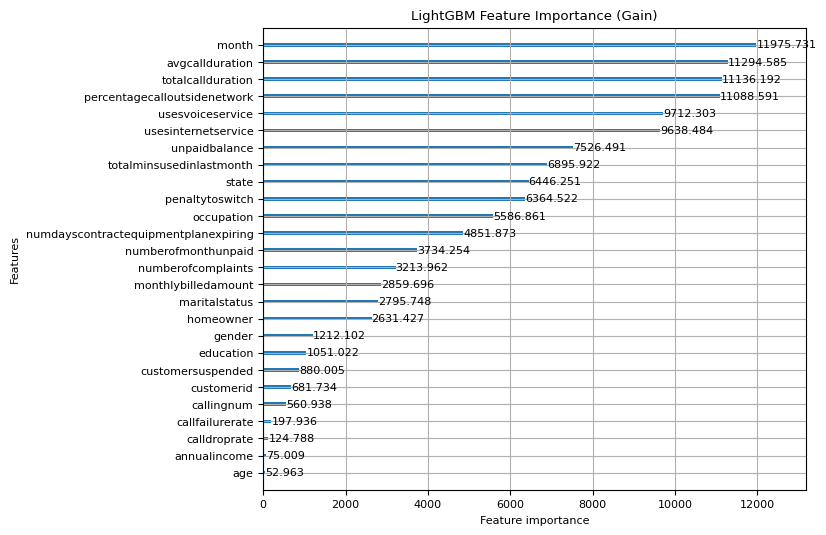

In [122]:
plt.rc('font', size=8)
lgb.plot_importance(best_mdl, importance_type="gain", figsize=(7,6),
                    title="LightGBM Feature Importance (Gain)").set_yticklabels(X.columns)
plt.show()